In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import openai
import random
import os
import collections
import copy

MEDIUM_SIZE = 18
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


with open('params.json') as f:
    params = json.load(f)

openai.api_key = params['OPENAI_API_KEY']
openai.organization = params['OPENAI_ORG']


def get_response(prompt, model='gpt-3.5-turbo', temperature=0.9, system_prompt="You are mimicking a real-life person who wants to make friends."):
    result = openai.ChatCompletion.create(
    model=model,
    temperature=temperature,
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
    ])

    return result.choices[0]['message']['content']


def summarize_reasons(filename):
    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    reason_list = collections.defaultdict(list)

    for d in data:        
        for result in d["reasons"]:
            if result and 'reason' in result.keys() and d['simulation'] == 0:
                reason_list[d['temperature']].append(result['reason'])


    for k, v in sorted(reason_list.items()):    
        print(f'For temperature {k} the top 3 reasons are:')
        prompt = f"""
        # Task
        You are given a list of reasons and your task is to summarize them. You must identify the general pattern in the reasons and summarize them in a few sentences.
        You should avoid identifying specific persons.

        # Input
        The input is a list of reasons. The list is given below after chevrons:
        <REASONS>
        {json.dumps(v, indent=4)}
        </REASONS>
        """

        ans = get_response(prompt, temperature=0.9, system_prompt="You are a helpful assistant")

        print(ans)

def print_reasons(filename):
    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    for d in data:
        if d["n"] == 50 and d["simulation"] == 0:
            print(f'n = {d["n"]}, simulation = {d["simulation"]}, temperature = {d["temperature"]}')
            print(d['reasons'])
            

def network_growth(n, k, beta, temperature, method='llm'):
    G = nx.Graph()

    # Create ring network
    for i in range(n):
        G.add_node(i)
    
    for i in G.nodes():
        G.add_edge(i, (i + 1) % n)

    for i in G.nodes():
        for j in G.nodes():
            if 0 < abs(i - j) % (n - 1 - k / 2) <= k / 2:
                G.add_edge(i, j)

    Gs = []
    results = []

    for i in G.nodes():
        neighbors = list(G.neighbors(i))
        for j in neighbors:
            if 0 < (j - i) % n <= k / 2:
                if np.random.uniform() <= beta:
                        while True:
                            if method == 'W-S':
                                v = random.choice(list(set(G.nodes())))
                            elif method == 'llm':
                                result = select_neighbor(G, i, temperature)
                                if not result:
                                    break
                                v = result['name']
                                
                            if v != i and v not in G.neighbors(i):
                                if method == 'llm':
                                    results.append(result)
                                G.add_edge(i, v)
                                G.remove_edge(i, j)
                                break     
                       
                        
        Gs.append(G.copy())

    return Gs, results

def select_neighbor(G, t, temperature):
    features = []
    for v in G.nodes():
        if v != t and v not in G.neighbors(t):
            features.append({'name' : v, 'neighbors' : list(G.neighbors(v))})

    prompt = f"""
    # Task
    Your task is to select a person to be friends with.

    # Input
    The input is a list of dictionaries. Each dictionary has two keys: 'name', 'neighbors'.
    'name' is the name of the person, and 'neighbors' is a list of the person's friends.
    The data is given below after chevrons:
    <DEGREES>
    {json.dumps(features, indent=4)}
    </DEGREES>

    # Output
    The output should be given in JSON format with the following structure

    {{
        "name" : name of the person you selected,
        "reason" : reason for selecting the person
    }}

    # Notes
    - The output must be a valid JSON object.

    ```json
    """   

    for i in range(10):
        try:
            result = json.loads(get_response(prompt, temperature=temperature).split('```')[0])
            if result['name'] in G.nodes():    
                print('NEW EDGE', result)
                return result 
        except Exception as e:
            print(e)
      

def run_network_formation_experiment(n_min, n_max, n_step, k, beta, num_simulations, outfile, temperatures, method):
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['k'], scenario['beta'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')


    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, k, beta, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, k={k} temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, k={k} temperature={temperature}')

                    Gs, reasons = network_growth(n, k, beta, temperature=temperature, method=method)

                    temp = {
                        'n' : n,
                        'k' : k,
                        'beta' : beta,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_lists(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax, G0=None):
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax, node_size=10, width=1.5, node_color='#d35400', alpha=0.7, edge_color='#2c3e50')
    ax.set_axis_off()
            
def analyze_experiments(filename):

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))


    average_shortest_path_lengths = collections.defaultdict(list)
    average_clustering_coefficients = collections.defaultdict(list)
    graphs = {}

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.Graph()

            for k, v in graph.items():
                k = int(k)
                G.add_node(k)
                for n in v:
                    G.add_edge(k, n)

            Gs.append(G)

        average_shortest_path_len = [nx.average_shortest_path_length(G) for G in Gs]
        average_clustering_coefficient = [nx.average_clustering(G) for G in Gs]
        average_shortest_path_lengths[d['n'], d['k'], d['beta'], d['temperature']].append(average_shortest_path_len)
        average_clustering_coefficients[d['n'], d['k'], d['beta'], d['temperature']].append(average_clustering_coefficient)

        graphs[d['n'], d['k'], d['beta'], d['temperature'], d['simulation']] = Gs[-1].copy()

    fig, ax = plt.subplots(1, len(average_shortest_path_lengths), figsize=(5 * len(average_shortest_path_lengths), 5), squeeze=False)

    i = 0

    for k in sorted(graphs.keys()):
        if k[-1] == 0:
            G = graphs[k]
            draw_graph(G, ax[0, i])
            ax[0, i].set_title(f'Temperature = {k[3]}')

            i += 1
        
    fig.tight_layout()
    # fig.suptitle('Graphs created with Principle 4', y=1.05)

    fig.savefig('figures/principle_4/principle_4_final_graphs.png')

    palette = ['#2980b9', '#f1c40f', '#7f8c8d', '#d35400', '#34495e', '#e67e22',]

    fig, ax = plt.subplots(2, len(average_shortest_path_lengths), figsize=(5 * len(average_shortest_path_lengths), 10), squeeze=False)
    fig_combined, ax_combined = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)

    ax_combined[0, 0].set_ylabel('Average Shortest Path Length')
    ax_combined[0, 1].set_ylabel('Algebraic Connectivity')
    ax_combined[0, 0].set_xlabel('t')
    ax_combined[0, 1].set_xlabel('t')


    for i, (k, c) in enumerate(zip(sorted(average_shortest_path_lengths.keys()), palette)):
        v = average_shortest_path_lengths[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))
        
        ax[0, i].plot(mean, color='#34495e', label='LLM')
        ax[0, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#34495e')

        ax[0, i].set_title(f'Temperature = {k[3]}')

        ax[0, i].set_xlabel('t')
        ax[0, i].set_ylabel('Average Shortest Path Length')

        ax[0, i].set_xlim(0, len(mean) - 1)

        ax_combined[0, 0].plot(mean, color=c, label='Temp = ' + str(k[3]))
        ax_combined[0, 0].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color=c)

    for i, (k, c) in enumerate(zip(sorted(average_clustering_coefficients.keys()), palette)):
        v = average_clustering_coefficients[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))
        
        ax[1, i].plot(mean, color='#34495e', label='LLM')
        ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#34495e')

        ax[1, i].set_ylabel('Average Clustering Coefficient')

        ax[1, i].set_xlabel('t')

        ax[1, i].set_xlim(0, len(mean) - 1)

        ax_combined[0, 1].plot(mean, color=c, label='Temp = ' + str(k[3]))
        ax_combined[0, 1].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color=c)

    # Null models
    average_shortest_path_lengths_null = { 'W-S' : collections.defaultdict(list), 'random' : collections.defaultdict(list) }
    average_clustering_coefficients_null = { 'W-S' : collections.defaultdict(list), 'random' : collections.defaultdict(list) }

    for d in data:
        for method in ['W-S']:
            if method == 'random':
                Gs, _ = network_growth(d['n'], d['k'], 1, d['temperature'], method='W-S')
            else:
                Gs, _ = network_growth(d['n'], d['k'], d['beta'], d['temperature'], method=method)
            average_shortest_path_lengths_null[method][d['n'], d['k'], d['beta'], d['temperature']].append([nx.average_shortest_path_length(G) for G in Gs])
            average_clustering_coefficients_null[method][d['n'], d['k'], d['beta'], d['temperature']].append([nx.average_clustering(G) for G in Gs])

    for method in ['W-S']:
        for i, (k, v) in enumerate(average_shortest_path_lengths_null[method].items()):
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            if method == 'W-S':
                ax[0, i].plot(mean, color='#d35400', linestyle='--', label=method)
            elif method == 'random':
                ax[0, i].plot(mean, color='#d35400', linestyle=':', label=method)
            
            ax[0, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400', hatch='||')

            if i == 0:
                ax_combined[0, 0].plot(mean, color='#d35400', linestyle='--', label=method)
                ax_combined[0, 0].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400', hatch='||')

    for method in ['W-S']:
        for i, (k, v) in enumerate(average_clustering_coefficients_null[method].items()):
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            if method == 'W-S':
                ax[1, i].plot(mean, color='#d35400', linestyle='--', label=method)
            elif method == 'random':
                ax[1, i].plot(mean, color='#d35400', linestyle=':', label=method)
            
            ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400', hatch='||')

            if i == 0:
                ax_combined[0, 1].plot(mean, color='#d35400', linestyle='--', label=method)
                ax_combined[0, 1].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400', hatch='||')
       
    for i in range(len(average_shortest_path_lengths)):
        ax[0, i].legend(loc='upper left')
        ax[1, i].legend(loc='upper left')

        ax[0, i].set_ylim(2, 3)

    ax_combined[0, 0].legend(loc='upper right')

    fig_combined.tight_layout()

    fig.tight_layout()

    fig.savefig('figures/principle_4/principle_4_overall.png')
   
    fig_combined.savefig('figures/principle_4/principle_4_overall_combined.png')

In [2]:
# LLM-based
run_network_formation_experiment(20, 20, 1, 5, 0.5, 10, 'outputs/principle_4.jsonl', [0.5, 1.0, 1.5], method='llm')

Skipping simulation for n=20, i=0, k=5 temperature=0.5
Skipping simulation for n=20, i=0, k=5 temperature=1.0
Skipping simulation for n=20, i=0, k=5 temperature=1.5
Skipping simulation for n=20, i=1, k=5 temperature=0.5
Skipping simulation for n=20, i=1, k=5 temperature=1.0
Skipping simulation for n=20, i=1, k=5 temperature=1.5
Skipping simulation for n=20, i=2, k=5 temperature=0.5
Skipping simulation for n=20, i=2, k=5 temperature=1.0
Skipping simulation for n=20, i=2, k=5 temperature=1.5
Skipping simulation for n=20, i=3, k=5 temperature=0.5
Skipping simulation for n=20, i=3, k=5 temperature=1.0
Skipping simulation for n=20, i=3, k=5 temperature=1.5
Skipping simulation for n=20, i=4, k=5 temperature=0.5
Skipping simulation for n=20, i=4, k=5 temperature=1.0
Skipping simulation for n=20, i=4, k=5 temperature=1.5
Skipping simulation for n=20, i=5, k=5 temperature=0.5
Skipping simulation for n=20, i=5, k=5 temperature=1.0
Skipping simulation for n=20, i=5, k=5 temperature=1.5
Skipping s

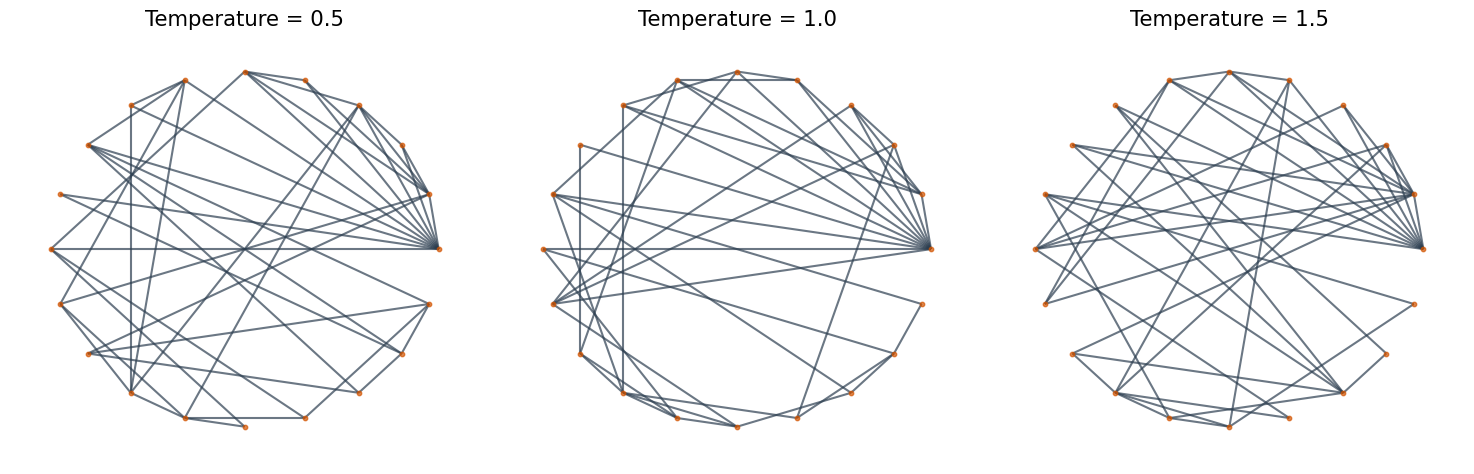

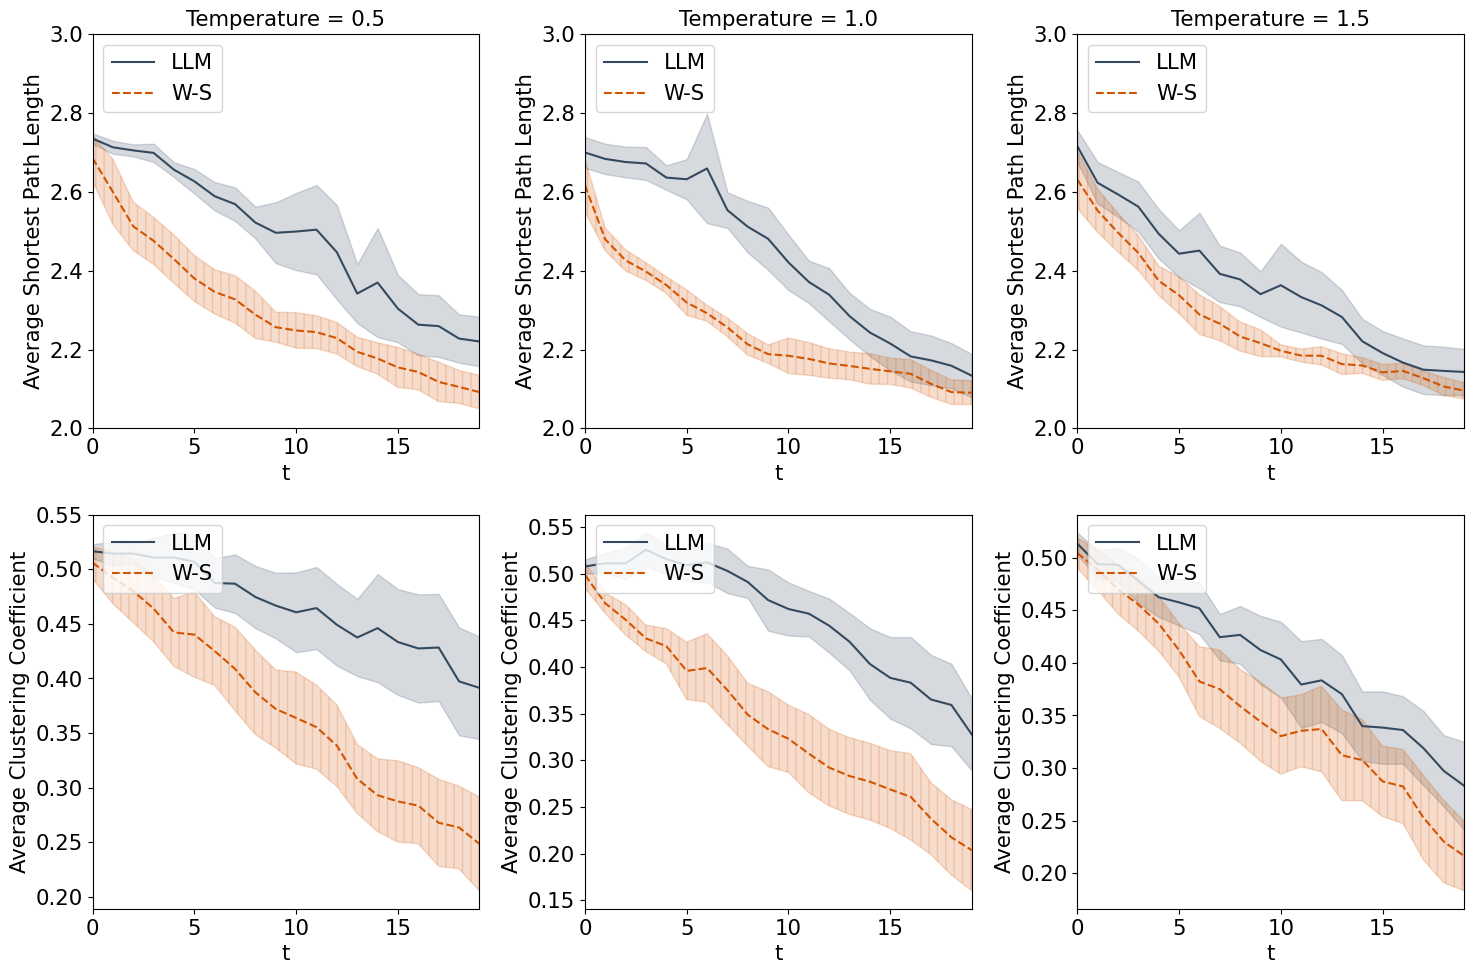

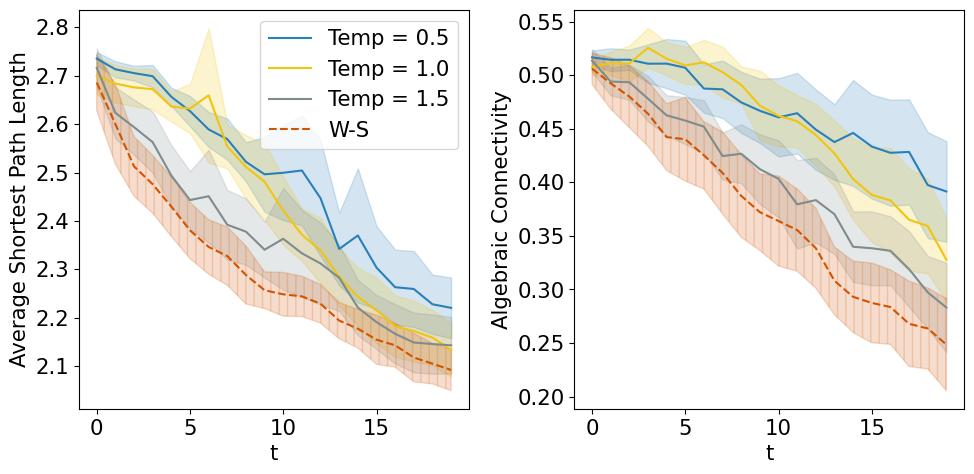

In [3]:
analyze_experiments('outputs/principle_4.jsonl')

In [ ]:
summarize_reasons('outputs/principle_4.jsonl')

: 